# 0 Set paths, devices, etc.

In [1]:
import numpy as np
import pandas as pd
import torch
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# notebook_login()

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
data_dir = 'drive/MyDrive/neuro2voc/task_1/data/'
# data_dir = '/home/zubat/Fei/Task_1/outputs/'

In [5]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

Using device: cpu



# 1 Load data and inspect

In [6]:
load_dir = data_dir+'1_extracted/'

In [7]:
paired_data_df_1 = pd.read_csv(load_dir+'extracted_data_1.csv')
paired_data_df_2 = pd.read_csv(load_dir+'extracted_data_2.csv')
paired_data_df_3 = pd.read_csv(load_dir+'extracted_data_3.csv')
combined_df = pd.concat([paired_data_df_1, paired_data_df_2, paired_data_df_3])

In [39]:
annotations_df_1 = pd.read_csv(load_dir+'clean_annotations_df_1.csv')
annotations_df_2 = pd.read_csv(load_dir+'clean_annotations_df_2.csv')
annotations_df_3 = pd.read_csv(load_dir+'clean_annotations_df_3.csv')
combined_annotation_df = pd.concat([annotations_df_1, annotations_df_2, annotations_df_3])

### Turning everything into integers..

In [40]:
annotations_df_1['onset'] = annotations_df_1['onset'].astype(int)
annotations_df_1['duration'] = annotations_df_1['duration'].astype(int)
annotations_df_2['onset'] = annotations_df_2['onset'].astype(int)
annotations_df_2['duration'] = annotations_df_2['duration'].astype(int)
annotations_df_3['onset'] = annotations_df_3['onset'].astype(int)
annotations_df_3['duration'] = annotations_df_3['duration'].astype(int)

In [10]:
annotations_df_3

,file,onset,duration,cluster_id
0,raw_g2_t0.nidq.bin,654656,1051,2
1,raw_g2_t0.nidq.bin,658668,1117,2
2,raw_g2_t0.nidq.bin,661498,3414,3
3,raw_g2_t0.nidq.bin,664913,1285,4
4,raw_g2_t0.nidq.bin,666438,2149,5
...,...,...,...,...
2846,raw_g2_t0.nidq.bin,82347286,666,6
2847,raw_g2_t0.nidq.bin,82348589,3939,7
2848,raw_g2_t0.nidq.bin,82353205,3171,3
2849,raw_g2_t0.nidq.bin,82356377,1524,4


In [11]:
annotations_df_1

,file,onset,duration,cluster_id
0,raw_g0_t0.nidq.bin,15521214,986,2
1,raw_g0_t0.nidq.bin,15525652,979,2
2,raw_g0_t0.nidq.bin,15576333,929,2
3,raw_g0_t0.nidq.bin,15583214,991,2
4,raw_g0_t0.nidq.bin,15588407,2960,3
...,...,...,...,...
412,raw_g0_t0.nidq.bin,54129833,1524,4
413,raw_g0_t0.nidq.bin,54131358,2568,5
414,raw_g0_t0.nidq.bin,54134039,598,6
415,raw_g0_t0.nidq.bin,54135124,3896,7


### Check class imbalance

There are no 8 label in annotations of file 1 and 2. After inspecting data directly, it is confirmed. Only 5 labels of 8 occured, and all of them are in file 3.

In [12]:
label_counts = combined_df.groupby('label').size().reset_index(name='count')
print(label_counts)

   label   count
0      2   50941
1      3  221798
2      4  106662
3      5  170050
4      6   39714
5      7  223318
6      8     919


In [13]:
unique_labels = annotations_df_3['cluster_id'].unique()

label2idx = {label: idx for idx, label in enumerate(unique_labels)}
label2idx

{2: 0, 3: 1, 4: 2, 5: 3, 6: 4, 7: 5, 8: 6}

In [14]:
def map_label2idx(label, mapping):
    return mapping.get(label, None)

In [41]:
combined_annotation_df['duration'] = combined_annotation_df['duration'] / 20

<ipython-input-29-b87e9e4f349d>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cluster_id', y='duration', data=combined_annotation_df, palette='coolwarm')


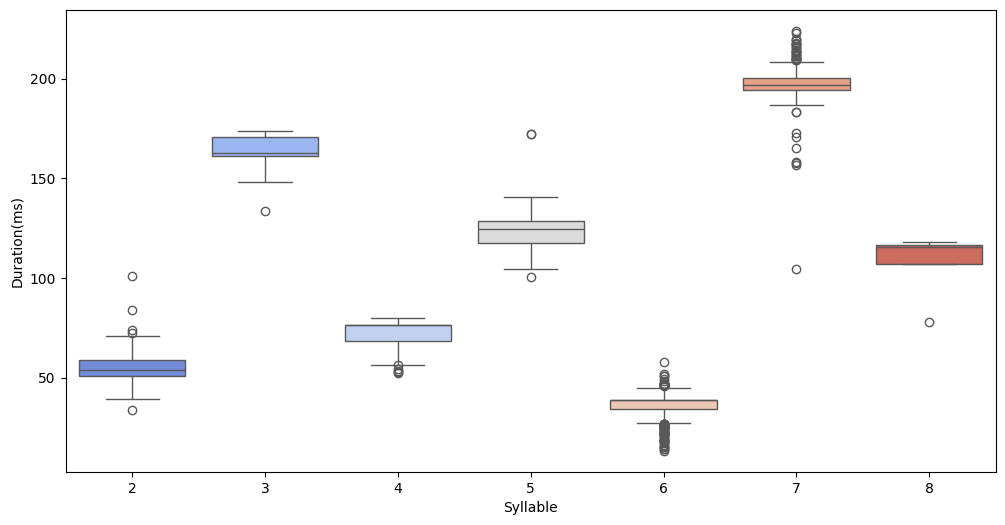

In [29]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='cluster_id', y='duration', data=combined_annotation_df, palette='coolwarm')

plt.xlabel('Syllable')
plt.ylabel('Duration(ms)')

plt.show()

In [34]:
from collections import Counter

In [36]:
def find_increasing_patterns(df, column, pattern_length):
    sequence = df[column].tolist()
    pattern_counter = Counter()

    for i in range(len(sequence) - pattern_length + 1):
        pattern = sequence[i:i+pattern_length]
        if all(pattern[j] <= pattern[j+1] for j in range(len(pattern) - 1)):
            pattern_counter[tuple(pattern)] += 1

    return pattern_counter

# Define the pattern length to search for
pattern_length = 6

# Find increasing patterns in the 'cluster_id' column
pattern_counts = find_increasing_patterns(combined_annotation_df, 'cluster_id', pattern_length)

# Get the most common patterns
most_common_patterns = pattern_counts.most_common()

print("Most common patterns:")
for pattern, count in most_common_patterns:
    print(f"{pattern}: {count}")

# Find the most frequent pattern
if most_common_patterns:
    most_frequent_pattern, most_frequent_pattern_count = most_common_patterns[0]
    print("\nMost frequent pattern:", most_frequent_pattern)
    print("Count:", most_frequent_pattern_count)
else:
    print("No patterns found.")

Most common patterns:
(2, 3, 4, 5, 6, 7): 211
(2, 2, 3, 4, 5, 6): 133
(2, 2, 2, 3, 4, 5): 65
(2, 2, 2, 2, 3, 4): 22
(2, 2, 2, 2, 2, 3): 7
(2, 2, 2, 2, 2, 2): 6
(2, 2, 2, 3, 4, 6): 1
(2, 2, 3, 4, 6, 7): 1
(2, 2, 3, 4, 5, 7): 1
(2, 2, 2, 3, 3, 4): 1
(2, 2, 3, 3, 4, 5): 1
(2, 3, 3, 4, 5, 6): 1
(3, 3, 4, 5, 6, 7): 1

Most frequent pattern: (2, 3, 4, 5, 6, 7)
Count: 211


In [42]:
# Sample DataFrame for illustration
# Function to find strictly increasing patterns of variable lengths in a column
def find_increasing_patterns(df, column, min_length, max_length):
    sequence = df[column].tolist()
    pattern_counter = Counter()
    patterns_found = []

    while len(sequence) >= min_length:
        found_pattern = False
        for length in range(max_length, min_length - 1, -1):
            for i in range(len(sequence) - length + 1):
                pattern = sequence[i:i+length]
                if all(pattern[j] <= pattern[j+1] for j in range(len(pattern) - 1)):
                    pattern_counter[tuple(pattern)] += 1
                    patterns_found.append((i, i+length))
                    found_pattern = True
                    break
            if found_pattern:
                break
        # Remove counted elements from the sequence
        if found_pattern:
            start, end = patterns_found[-1]
            sequence = sequence[:start] + sequence[end:]
        else:
            break

    return pattern_counter

# Define the range of pattern lengths to search for
min_pattern_length = 2
max_pattern_length = 7

# Find increasing patterns in the 'cluster_id' column
pattern_counts = find_increasing_patterns(combined_annotation_df, 'cluster_id', min_pattern_length, max_pattern_length)

# Get the most common patterns
most_common_patterns = pattern_counts.most_common()

print("Most common patterns:")
for pattern, count in most_common_patterns:
    print(f"{pattern}: {count}")

# Find the most frequent pattern
if most_common_patterns:
    most_frequent_pattern, most_frequent_pattern_count = most_common_patterns[0]
    print("\nMost frequent pattern:", most_frequent_pattern)
    print("Count:", most_frequent_pattern_count)
else:
    print("No patterns found.")

Most common patterns:
(3, 4, 5, 6, 7): 309
(2, 3, 4, 5, 6, 7): 74
(2, 2, 3, 4, 5, 6, 7): 68
(2, 2, 2, 3, 4, 5, 6): 43
(3, 4, 5): 35
(3, 4, 5, 7): 17
(2, 2, 2, 2, 3, 4, 5): 15
(3, 4, 5, 6, 7, 7): 14
(3, 3, 4, 5, 6, 7): 6
(3, 4, 5, 7, 7): 6
(2, 3, 4, 5, 6, 7, 7): 5
(2, 3, 4, 5): 5
(2, 2, 2, 2, 2, 3, 4): 4
(3, 4, 5, 5, 6, 7): 4
(4, 5, 6, 7): 3
(3, 7): 3
(2, 2, 2, 2, 2, 2, 2): 2
(3, 3, 4, 5, 6, 7, 7): 2
(2, 2, 3, 4, 5): 2
(2, 3, 4, 5, 7): 2
(3, 4, 5, 6, 6, 7): 2
(6, 7): 2
(2, 8): 2
(2, 2, 2, 2, 2, 2, 3): 1
(2, 2, 2, 3, 4, 6, 7): 1
(3, 4, 5, 6, 7, 7, 7): 1
(2, 2, 2, 3, 3, 4, 5): 1
(2, 2, 3, 4, 5, 7): 1
(2, 3, 3, 4, 5, 6, 7): 1
(2, 3, 4, 5, 7, 7): 1
(2, 3, 4, 5, 6): 1
(3, 4, 6, 7): 1
(2, 2, 2, 8): 1
(3, 4, 5, 6): 1
(2, 8, 8): 1
(3, 6, 7): 1
(3, 4): 1

Most frequent pattern: (3, 4, 5, 6, 7)
Count: 309


In [43]:
def find_strictly_increasing_patterns(df, column, min_length, max_length):
    sequence = df[column].tolist()
    pattern_counter = Counter()
    patterns_found = []

    while len(sequence) >= min_length:
        found_pattern = False
        for length in range(max_length, min_length - 1, -1):
            for i in range(len(sequence) - length + 1):
                pattern = sequence[i:i+length]
                if all(pattern[j] < pattern[j+1] for j in range(len(pattern) - 1)):
                    pattern_counter[tuple(pattern)] += 1
                    patterns_found.append((i, i+length))
                    found_pattern = True
                    break
            if found_pattern:
                break
        # Remove counted elements from the sequence
        if found_pattern:
            start, end = patterns_found[-1]
            sequence = sequence[:start] + sequence[end:]
        else:
            break

    return pattern_counter

# Define the range of pattern lengths to search for
min_pattern_length = 2
max_pattern_length = 8

# Find strictly increasing patterns in the 'cluster_id' column
pattern_counts = find_strictly_increasing_patterns(combined_annotation_df, 'cluster_id', min_pattern_length, max_pattern_length)

# Get the most common patterns
most_common_patterns = pattern_counts.most_common()

print("Most common patterns:")
for pattern, count in most_common_patterns:
    print(f"{pattern}: {count}")

# Find the most frequent pattern
if most_common_patterns:
    most_frequent_pattern, most_frequent_pattern_count = most_common_patterns[0]
    print("\nMost frequent pattern:", most_frequent_pattern)
    print("Count:", most_frequent_pattern_count)
else:
    print("No patterns found.")

Most common patterns:
(2, 3, 4, 5, 6, 7): 385
(3, 4, 5, 6, 7): 148
(2, 3, 4, 5): 38
(3, 4, 5): 29
(2, 3): 14
(2, 3, 4, 5, 7): 11
(3, 4, 5, 7): 6
(2, 8): 5
(2, 3, 4, 5, 6): 3
(4, 5, 6, 7): 2
(2, 3, 4, 6, 7): 1
(3, 4, 6, 7): 1
(3, 4, 5, 6): 1
(2, 3, 4): 1

Most frequent pattern: (2, 3, 4, 5, 6, 7)
Count: 385


In [44]:
def find_repetitive_patterns(df, column, min_length, max_length):
    sequence = df[column].tolist()
    pattern_counter = Counter()
    patterns_found = []

    while len(sequence) >= min_length:
        found_pattern = False
        for length in range(max_length, min_length - 1, -1):
            for i in range(len(sequence) - length + 1):
                pattern = sequence[i:i+length]
                if all(pattern[j] == pattern[j+1] for j in range(len(pattern) - 1)):
                    pattern_counter[tuple(pattern)] += 1
                    patterns_found.append((i, i+length))
                    found_pattern = True
                    break
            if found_pattern:
                break
        # Remove counted elements from the sequence
        if found_pattern:
            start, end = patterns_found[-1]
            sequence = sequence[:start] + sequence[end:]
        else:
            break

    return pattern_counter

# Define the range of pattern lengths to search for
min_pattern_length = 2
max_pattern_length = 8

# Find repetitive patterns in the 'cluster_id' column
pattern_counts = find_repetitive_patterns(combined_annotation_df, 'cluster_id', min_pattern_length, max_pattern_length)

# Get the most common patterns
most_common_patterns = pattern_counts.most_common()

print("Most common patterns:")
for pattern, count in most_common_patterns:
    print(f"{pattern}: {count}")

# Find the most frequent pattern
if most_common_patterns:
    most_frequent_pattern, most_frequent_pattern_count = most_common_patterns[0]
    print("\nMost frequent pattern:", most_frequent_pattern)
    print("Count:", most_frequent_pattern_count)
else:
    print("No patterns found.")

Most common patterns:
(2, 2): 71
(2, 2, 2): 46
(2, 2, 2, 2): 15
(3, 3): 11
(2, 2, 2, 2, 2): 4
(2, 2, 2, 2, 2, 2, 2, 2): 1
(2, 2, 2, 2, 2, 2, 2): 1
(2, 2, 2, 2, 2, 2): 1
(8, 8): 1

Most frequent pattern: (2, 2)
Count: 71


In [103]:
import networkx as nx
import matplotlib.patches as patches
from matplotlib.patches import Arc, RegularPolygon
from numpy import radians as rad

In [89]:
patterns = {
    (2, 3, 4, 5, 6, 7): 385,
    (3, 4, 5, 6, 7): 148,
    (2, 3, 4, 5): 38,
    (3, 4, 5): 29,
    (2, 3): 14,
    (2, 3, 4, 5, 7): 11,
    (3, 4, 5, 7): 6,
    (2, 8): 5,
    (2, 2): 71,
}

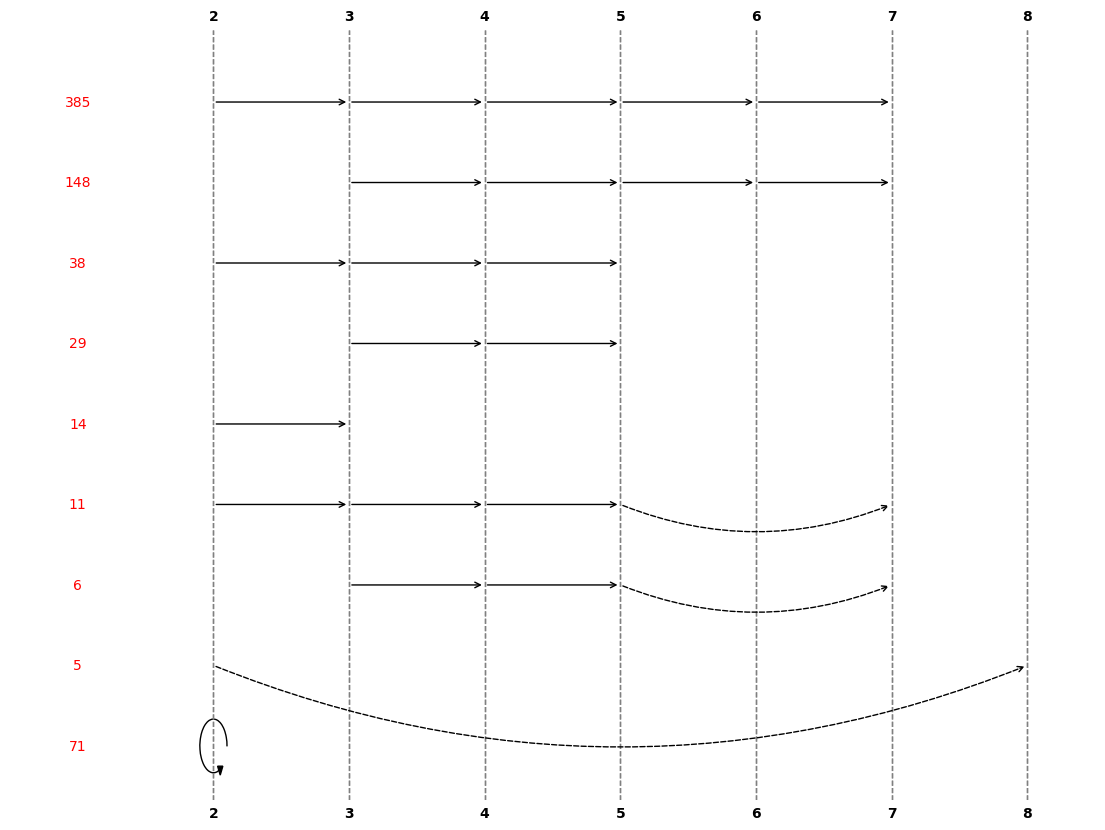

In [133]:
# Set up the figure and axes
fig, ax = plt.subplots(figsize=(14, 10))

# Define the labels
labels = [2, 3, 4, 5, 6, 7, 8]

# Draw the columns for each label with higher zorder
for i, label in enumerate(labels):
    ax.text(i, len(patterns) * 0.23+0.05, label, ha='center', va='center', fontweight='bold', fontsize=10, zorder=5)
    ax.axvline(x=i, color='gray', linestyle='--', linewidth=1, zorder=3)

for i, label in enumerate(labels):
    ax.text(i, -0.85, label, ha='center', va='center', fontweight='bold', fontsize=10, zorder=5)
    ax.axvline(x=i, color='gray', linestyle='--', linewidth=1, zorder=3)

# Set up the grid limits
ax.set_xlim(-1.5, len(labels) - 0.5)
ax.set_ylim(-0.8, len(patterns) * 0.23)
ax.axis('off')

# Function to draw circular arrows
def draw_circular_arrow(ax, radius, centX, centY, angle_, theta2_, color_='black'):
    # Line
    arc = Arc([centX, centY], radius, radius, angle=angle_,
              theta1=0, theta2=theta2_, capstyle='round', linestyle='-', lw=1, color=color_)
    ax.add_patch(arc)

    # Arrow head
    endX = centX + (radius / 2) * np.cos(rad(theta2_ + angle_))
    endY = centY + (radius / 2) * np.sin(rad(theta2_ + angle_))

    ax.add_patch(  # Create triangle as arrow head
        RegularPolygon(
            (endX, endY),  # (x,y)
            numVertices=3,  # number of vertices
            radius=radius / 9,  # radius
            orientation=rad(angle_ + theta2_),  # orientation
            color=color_
        )
    )

# Function to draw arrows for each pattern
def draw_arrows(pattern, count, y_pos):
    start = labels.index(pattern[0])
    end = labels.index(pattern[-1])

    # Add count number at the left side of the graph
    ax.text(-1, y_pos, str(count), ha='center', va='center', color='red', fontsize=10, zorder=5)

    # Check if the pattern is a self-loop
    if len(pattern) == 2 and pattern[0] == pattern[1]:
        # Draw a circular self-loop arrow
        draw_circular_arrow(ax, 0.2, start, y_pos, 0, 300)
    else:
        # Draw arrows for all transitions
        for i in range(len(pattern) - 1):
            start = labels.index(pattern[i])
            end = labels.index(pattern[i + 1])
            if end == start + 1:
                # Direct arrow for contiguous parts
                ax.annotate('',
                            xy=(end, y_pos),
                            xytext=(start, y_pos),
                            arrowprops=dict(arrowstyle='->', lw=1, color='black'))
            else:
                # Dashed curved arrow for non-contiguous transitions
                rad = 0.2 if start < end else -0.2
                ax.annotate('',
                            xy=(end, y_pos),
                            xytext=(start, y_pos),
                            arrowprops=dict(arrowstyle='->', lw=1, linestyle='dashed', color='black', connectionstyle=f"arc3,rad={rad}"))

# Draw the arrows for each pattern in the specified order
current_y = len(patterns) * 0.2
for pattern, count in patterns.items():
    draw_arrows(pattern, count, current_y)
    current_y -= 0.3

# Title
# plt.title('Frequent Pattern Transitions', zorder=5)

# Show the plot
plt.show()

# 2 Tensorize the data

In [ ]:
tensor_dir = data_dir + "2_tensors/"

### 2.1 Stripe them directly

In [ ]:
def map_label2idx(label, mapping):
    return mapping.get(label, )

def stripe_data2tensor(annotations_df, paired_data_df, label2idx, directory, file, batch_size=30, num_neurons=75):
    # prepare data
    # sort the data for iteration
    paired_data_df = paired_data_df.sort_values(by='sample_round')
    # create idx column to map cluster_id to idx, this is the label
    annotations_df['idx'] = annotations_df['cluster_id'].apply(lambda x: map_label2idx(x, label2idx))
    # the annotation_df is sorted already

    # initialize
    # data list
    data = []
    # data tensor
    # num_batches = (paired_data_df['sample_round'].max() - 1) // batch_size
    # all_firing_patterns = torch.zeros((num_batches, num_neurons, batch_size), dtype=torch.int)
    # labels list
    labels = []

    # the loop
    # iterate through annotations
    for _, annotation in tqdm(annotations_df.iterrows(), total=annotations_df.shape[0], desc="Processing entries"):

        # for each entry(row/annotation) in annotation file, we have these basic values
        onset = annotation['onset']
        duration = annotation['duration']
        offset = onset + duration
        label_idx = annotation['idx']

        # now divide each entry in the annotation file into multiple sampling batches
        for batch_start in range(onset, offset, batch_size):
            # one batch is one entry in data of dimension num_neurons x batch_size

            # calculate the end and skip if the batch is not complete
            batch_end = batch_start + batch_size
            if batch_end > offset:
                break

            # initialize tensor for this batch
            batch_tensor = torch.zeros((num_neurons, batch_size), dtype=torch.int)

            # use this batch start and end information to find the batch in the paired_data
            batch_data = paired_data_df[(paired_data_df['sample_round'] >= batch_start) & (paired_data_df['sample_round'] < batch_end)]

            # now divide each datapoitns in this batch into individual sampling points
            for _, data_row in batch_data.iterrows():

                # for each point of spike, get the place/index of neuron
                neuron_index = int(data_row['idx'])
                # calculate the relative time within batch
                time_within_batch = int(data_row['sample_round']) - batch_start # 25002 - 25000 = 2, data[2] is the third in the list, correct.

                # use above place and time to mark the spike
                batch_tensor[neuron_index, time_within_batch] = 1

            # add label for this batch
            data.append(batch_tensor)
            # for this batch, add labels
            labels.append(label_idx)

    data_tensor = torch.stack(data)
    labels_tensor = torch.tensor(labels)


    # dimension check
    if len(labels) != data_tensor.shape[0] or \
       num_neurons != data_tensor.shape[1] or \
       batch_size != data_tensor.shape[2]:
        print("Error: Dimension mismatch in final firing patterns tensor.")

    data_path_name = f"{directory}data_{file}_{batch_size}.pt"
    labels_path_name = f"{directory}labels_{file}_{batch_size}.pt"
    torch.save(data_tensor, data_path_name)
    torch.save(labels_tensor, labels_path_name)
    print(f"Data saved to {data_path_name}")
    print(f"Labels saved to {labels_path_name}")

    return data_tensor, labels

In [ ]:
tensors_1_30, labels_1_30 = stripe_data2tensor(annotations_df_1, paired_data_df_1, label2idx, tensor_dir, 1, batch_size=30)
tensors_1_60, labels_1_60 = stripe_data2tensor(annotations_df_1, paired_data_df_1, label2idx, tensor_dir, 1, batch_size=60)
tensors_1_120, labels_1_120 = stripe_data2tensor(annotations_df_1, paired_data_df_1, label2idx, tensor_dir, 1, batch_size=120)

Processing entries:   0%|          | 0/417 [00:00<?, ?it/s]

Processing entries: 100%|██████████| 417/417 [00:19<00:00, 21.94it/s]


Data saved to /home/zubat/Fei/Task_1/outputs/2_tensors/data_1_30.pt
Labels saved to /home/zubat/Fei/Task_1/outputs/2_tensors/labels_1_30.pt


Processing entries: 100%|██████████| 417/417 [00:11<00:00, 35.96it/s]


Data saved to /home/zubat/Fei/Task_1/outputs/2_tensors/data_1_60.pt
Labels saved to /home/zubat/Fei/Task_1/outputs/2_tensors/labels_1_60.pt


Processing entries: 100%|██████████| 417/417 [00:08<00:00, 51.93it/s]


Data saved to /home/zubat/Fei/Task_1/outputs/2_tensors/data_1_120.pt
Labels saved to /home/zubat/Fei/Task_1/outputs/2_tensors/labels_1_120.pt


In [ ]:
tensors_2_30, labels_2_30 = stripe_data2tensor(annotations_df_2, paired_data_df_2, label2idx, tensor_dir, 2, batch_size=30)
tensors_2_60, labels_2_60 = stripe_data2tensor(annotations_df_2, paired_data_df_2, label2idx, tensor_dir, 2, batch_size=60)
tensors_2_120, labels_2_120 = stripe_data2tensor(annotations_df_2, paired_data_df_2, label2idx, tensor_dir, 2, batch_size=120)

Processing entries: 100%|██████████| 191/191 [00:07<00:00, 27.13it/s]


Data saved to /home/zubat/Fei/Task_1/outputs/2_tensors/data_2_30.pt
Labels saved to /home/zubat/Fei/Task_1/outputs/2_tensors/labels_2_30.pt


Processing entries: 100%|██████████| 191/191 [00:04<00:00, 42.70it/s]


Data saved to /home/zubat/Fei/Task_1/outputs/2_tensors/data_2_60.pt
Labels saved to /home/zubat/Fei/Task_1/outputs/2_tensors/labels_2_60.pt


Processing entries: 100%|██████████| 191/191 [00:03<00:00, 63.45it/s]


Data saved to /home/zubat/Fei/Task_1/outputs/2_tensors/data_2_120.pt
Labels saved to /home/zubat/Fei/Task_1/outputs/2_tensors/labels_2_120.pt


In [ ]:
tensors_3_30, labels_3_30 = stripe_data2tensor(annotations_df_3, paired_data_df_3, label2idx, tensor_dir, 3, batch_size=30)
tensors_3_60, labels_3_60 = stripe_data2tensor(annotations_df_3, paired_data_df_3, label2idx, tensor_dir, 3, batch_size=60)
tensors_3_120, labels_3_120 = stripe_data2tensor(annotations_df_3, paired_data_df_3, label2idx, tensor_dir, 3, batch_size=120)

Processing entries:   0%|          | 0/2851 [00:00<?, ?it/s]

Processing entries: 100%|██████████| 2851/2851 [06:02<00:00,  7.87it/s]


Data saved to /home/zubat/Fei/Task_1/outputs/2_tensors/data_3_30.pt
Labels saved to /home/zubat/Fei/Task_1/outputs/2_tensors/labels_3_30.pt


Processing entries: 100%|██████████| 2851/2851 [03:08<00:00, 15.14it/s]


Data saved to /home/zubat/Fei/Task_1/outputs/2_tensors/data_3_60.pt
Labels saved to /home/zubat/Fei/Task_1/outputs/2_tensors/labels_3_60.pt


Processing entries: 100%|██████████| 2851/2851 [01:52<00:00, 25.27it/s]


Data saved to /home/zubat/Fei/Task_1/outputs/2_tensors/data_3_120.pt
Labels saved to /home/zubat/Fei/Task_1/outputs/2_tensors/labels_3_120.pt


In [ ]:
tensors_1_300, labels_1_300 = stripe_data2tensor(annotations_df_1, paired_data_df_1, label2idx, tensor_dir, 1, batch_size=300)
tensors_2_300, labels_2_300 = stripe_data2tensor(annotations_df_2, paired_data_df_2, label2idx, tensor_dir, 2, batch_size=300)
tensors_3_300, labels_3_300 = stripe_data2tensor(annotations_df_3, paired_data_df_3, label2idx, tensor_dir, 3, batch_size=300)

Processing entries: 100%|██████████| 417/417 [00:12<00:00, 33.02it/s]


Data saved to drive/MyDrive/neuro2voc/task_1/data/2_tensors/data_1_300.pt
Labels saved to drive/MyDrive/neuro2voc/task_1/data/2_tensors/labels_1_300.pt


Processing entries: 100%|██████████| 191/191 [00:06<00:00, 27.97it/s]


Data saved to drive/MyDrive/neuro2voc/task_1/data/2_tensors/data_2_300.pt
Labels saved to drive/MyDrive/neuro2voc/task_1/data/2_tensors/labels_2_300.pt


Processing entries: 100%|██████████| 2851/2851 [02:05<00:00, 22.79it/s]


Data saved to drive/MyDrive/neuro2voc/task_1/data/2_tensors/data_3_300.pt
Labels saved to drive/MyDrive/neuro2voc/task_1/data/2_tensors/labels_3_300.pt


In [ ]:
tensors_1_400, labels_1_400 = stripe_data2tensor(annotations_df_1, paired_data_df_1, label2idx, tensor_dir, 1, batch_size=400)
tensors_2_400, labels_2_400 = stripe_data2tensor(annotations_df_2, paired_data_df_2, label2idx, tensor_dir, 2, batch_size=400)
tensors_3_400, labels_3_400 = stripe_data2tensor(annotations_df_3, paired_data_df_3, label2idx, tensor_dir, 3, batch_size=400)

Processing entries: 100%|██████████| 417/417 [00:11<00:00, 36.19it/s]


Data saved to drive/MyDrive/neuro2voc/task_1/data/2_tensors/data_1_400.pt
Labels saved to drive/MyDrive/neuro2voc/task_1/data/2_tensors/labels_1_400.pt


Processing entries: 100%|██████████| 191/191 [00:06<00:00, 30.96it/s]


Data saved to drive/MyDrive/neuro2voc/task_1/data/2_tensors/data_2_400.pt
Labels saved to drive/MyDrive/neuro2voc/task_1/data/2_tensors/labels_2_400.pt


Processing entries: 100%|██████████| 2851/2851 [01:37<00:00, 29.39it/s]


Data saved to drive/MyDrive/neuro2voc/task_1/data/2_tensors/data_3_400.pt
Labels saved to drive/MyDrive/neuro2voc/task_1/data/2_tensors/labels_3_400.pt


In [ ]:
tensors_1_500, labels_1_500 = stripe_data2tensor(annotations_df_1, paired_data_df_1, label2idx, tensor_dir, 1, batch_size=500)
tensors_2_500, labels_2_500 = stripe_data2tensor(annotations_df_2, paired_data_df_2, label2idx, tensor_dir, 2, batch_size=500)
tensors_3_500, labels_3_500 = stripe_data2tensor(annotations_df_3, paired_data_df_3, label2idx, tensor_dir, 3, batch_size=500)

Processing entries: 100%|██████████| 417/417 [00:11<00:00, 35.39it/s]


Data saved to drive/MyDrive/neuro2voc/task_1/data/2_tensors/data_1_500.pt
Labels saved to drive/MyDrive/neuro2voc/task_1/data/2_tensors/labels_1_500.pt


Processing entries: 100%|██████████| 191/191 [00:06<00:00, 27.30it/s]


Data saved to drive/MyDrive/neuro2voc/task_1/data/2_tensors/data_2_500.pt
Labels saved to drive/MyDrive/neuro2voc/task_1/data/2_tensors/labels_2_500.pt


Processing entries: 100%|██████████| 2851/2851 [01:33<00:00, 30.43it/s]


Data saved to drive/MyDrive/neuro2voc/task_1/data/2_tensors/data_3_500.pt
Labels saved to drive/MyDrive/neuro2voc/task_1/data/2_tensors/labels_3_500.pt


In [ ]:
tensors_1_600, labels_1_600 = stripe_data2tensor(annotations_df_1, paired_data_df_1, label2idx, tensor_dir, 1, batch_size=600)
tensors_2_600, labels_2_600 = stripe_data2tensor(annotations_df_2, paired_data_df_2, label2idx, tensor_dir, 2, batch_size=600)
tensors_3_600, labels_3_600 = stripe_data2tensor(annotations_df_3, paired_data_df_3, label2idx, tensor_dir, 3, batch_size=600)

Processing entries: 100%|██████████| 417/417 [00:12<00:00, 34.50it/s]


Data saved to drive/MyDrive/neuro2voc/task_1/data/2_tensors/data_1_600.pt
Labels saved to drive/MyDrive/neuro2voc/task_1/data/2_tensors/labels_1_600.pt


Processing entries: 100%|██████████| 191/191 [00:11<00:00, 17.01it/s]


Data saved to drive/MyDrive/neuro2voc/task_1/data/2_tensors/data_2_600.pt
Labels saved to drive/MyDrive/neuro2voc/task_1/data/2_tensors/labels_2_600.pt


Processing entries: 100%|██████████| 2851/2851 [01:16<00:00, 37.33it/s]


Data saved to drive/MyDrive/neuro2voc/task_1/data/2_tensors/data_3_600.pt
Labels saved to drive/MyDrive/neuro2voc/task_1/data/2_tensors/labels_3_600.pt


In [ ]:
tensors_1_1, labels_1_1 = stripe_data2tensor(annotations_df_1, paired_data_df_1, label2idx, tensor_dir, 1, batch_size=1)
tensors_2_1, labels_2_1 = stripe_data2tensor(annotations_df_2, paired_data_df_2, label2idx, tensor_dir, 2, batch_size=1)
tensors_3_1, labels_3_1 = stripe_data2tensor(annotations_df_3, paired_data_df_3, label2idx, tensor_dir, 3, batch_size=1)

Processing entries: 100%|██████████| 417/417 [14:52<00:00,  2.14s/it]


Data saved to drive/MyDrive/neuro2voc/task_1/data/2_tensors/data_1_1.pt
Labels saved to drive/MyDrive/neuro2voc/task_1/data/2_tensors/labels_1_1.pt


Processing entries: 100%|██████████| 191/191 [06:10<00:00,  1.94s/it]


Data saved to drive/MyDrive/neuro2voc/task_1/data/2_tensors/data_2_1.pt
Labels saved to drive/MyDrive/neuro2voc/task_1/data/2_tensors/labels_2_1.pt


Processing entries:   6%|▌         | 172/2851 [19:57<5:10:44,  6.96s/it]


KeyboardInterrupt: 

In [ ]:
tensors_1_900, labels_1_900 = stripe_data2tensor(annotations_df_1, paired_data_df_1, label2idx, tensor_dir, 1, batch_size=900)
tensors_2_900, labels_2_900 = stripe_data2tensor(annotations_df_2, paired_data_df_2, label2idx, tensor_dir, 2, batch_size=900)
tensors_3_900, labels_3_900 = stripe_data2tensor(annotations_df_3, paired_data_df_3, label2idx, tensor_dir, 3, batch_size=900)

Processing entries: 100%|██████████| 417/417 [00:07<00:00, 54.69it/s]


Data saved to drive/MyDrive/neuro2voc/task_1/data/2_tensors/data_1_900.pt
Labels saved to drive/MyDrive/neuro2voc/task_1/data/2_tensors/labels_1_900.pt


Processing entries: 100%|██████████| 191/191 [00:05<00:00, 34.58it/s]


Data saved to drive/MyDrive/neuro2voc/task_1/data/2_tensors/data_2_900.pt
Labels saved to drive/MyDrive/neuro2voc/task_1/data/2_tensors/labels_2_900.pt


Processing entries: 100%|██████████| 2851/2851 [01:08<00:00, 41.33it/s]


Data saved to drive/MyDrive/neuro2voc/task_1/data/2_tensors/data_3_900.pt
Labels saved to drive/MyDrive/neuro2voc/task_1/data/2_tensors/labels_3_900.pt


In [ ]:
tensors_1_1200, labels_1_1200 = stripe_data2tensor(annotations_df_1, paired_data_df_1, label2idx, tensor_dir, 1, batch_size=1200)
tensors_2_1200, labels_2_1200 = stripe_data2tensor(annotations_df_2, paired_data_df_2, label2idx, tensor_dir, 2, batch_size=1200)
tensors_3_1200, labels_3_1200 = stripe_data2tensor(annotations_df_3, paired_data_df_3, label2idx, tensor_dir, 3, batch_size=1200)

Processing entries: 100%|██████████| 417/417 [00:06<00:00, 61.53it/s]


Data saved to drive/MyDrive/neuro2voc/task_1/data/2_tensors/data_1_1200.pt
Labels saved to drive/MyDrive/neuro2voc/task_1/data/2_tensors/labels_1_1200.pt


Processing entries: 100%|██████████| 191/191 [00:02<00:00, 65.99it/s]


Data saved to drive/MyDrive/neuro2voc/task_1/data/2_tensors/data_2_1200.pt
Labels saved to drive/MyDrive/neuro2voc/task_1/data/2_tensors/labels_2_1200.pt


Processing entries: 100%|██████████| 2851/2851 [01:08<00:00, 41.32it/s]


Data saved to drive/MyDrive/neuro2voc/task_1/data/2_tensors/data_3_1200.pt
Labels saved to drive/MyDrive/neuro2voc/task_1/data/2_tensors/labels_3_1200.pt


### 2.2 With sliding window + One tensor for one batch_size

In [ ]:
def map_label2idx(label, mapping):
    return mapping.get(label, )

def aggregate_data2tensor(annotations_df, paired_data_df, label2idx, directory, file, batch_size, step_size, num_neurons=75):
    # prepare data
    paired_data_df = paired_data_df.sort_values(by='sample_round')
    annotations_df['idx'] = annotations_df['cluster_id'].apply(lambda x: map_label2idx(x, label2idx))

    # data list and labels list
    data = []
    labels = []

    # iterate through annotations
    for _, annotation in tqdm(annotations_df.iterrows(), total=annotations_df.shape[0], desc="Processing entries"):
        onset = annotation['onset']
        duration = annotation['duration']
        offset = onset + duration
        label_idx = annotation['idx']

        # divide each entry into multiple sampling batches
        for batch_start in range(onset, offset - batch_size + 1, step_size):
            batch_end = batch_start + batch_size
            if batch_end > offset:
                break

            # initialize tensor for this batch (only neurons, no time points)
            batch_tensor = torch.zeros(num_neurons, dtype=torch.int)

            # find the batch in the paired_data
            batch_data = paired_data_df[(paired_data_df['sample_round'] >= batch_start) & (paired_data_df['sample_round'] < batch_end)]

            # mark spikes
            for _, data_row in batch_data.iterrows():
                neuron_index = int(data_row['idx'])
                batch_tensor[neuron_index] = 1  # mark the neuron as spiked

            # add tensor and label for this batch
            data.append(batch_tensor)
            labels.append(label_idx)

    data_tensor = torch.stack(data)
    labels_tensor = torch.tensor(labels)

    # save data and labels
    data_path_name = f"{directory}data_{file}_{batch_size}_aggregated.pt"
    labels_path_name = f"{directory}labels_{file}_{batch_size}_aggregated.pt"
    torch.save(data_tensor, data_path_name)
    torch.save(labels_tensor, labels_path_name)
    print(f"Data saved to {data_path_name}")
    print(f"Labels saved to {labels_path_name}")

    return data_tensor, labels_tensor

In [ ]:
tensors_1_40, labels_1_40 = aggregate_data2tensor(annotations_df_1, paired_data_df_1, label2idx, tensor_dir, 1, batch_size=40, step_size=5)
tensors_2_40, labels_2_40 = aggregate_data2tensor(annotations_df_2, paired_data_df_2, label2idx, tensor_dir, 2, batch_size=40, step_size=5)
tensors_3_40, labels_3_40 = aggregate_data2tensor(annotations_df_3, paired_data_df_3, label2idx, tensor_dir, 3, batch_size=40, step_size=5)

Processing entries: 100%|██████████| 417/417 [04:10<00:00,  1.66it/s]


Data saved to drive/MyDrive/neuro2voc/task_1/data/2_tensors/data_1_40_aggregated.pt
Labels saved to drive/MyDrive/neuro2voc/task_1/data/2_tensors/labels_1_40_aggregated.pt


Processing entries: 100%|██████████| 191/191 [01:34<00:00,  2.03it/s]


Data saved to drive/MyDrive/neuro2voc/task_1/data/2_tensors/data_2_40_aggregated.pt
Labels saved to drive/MyDrive/neuro2voc/task_1/data/2_tensors/labels_2_40_aggregated.pt


Processing entries: 100%|██████████| 2851/2851 [1:09:03<00:00,  1.45s/it]


Data saved to drive/MyDrive/neuro2voc/task_1/data/2_tensors/data_3_40_aggregated.pt
Labels saved to drive/MyDrive/neuro2voc/task_1/data/2_tensors/labels_3_40_aggregated.pt


### 2.3 Total spikes and Normalized spikes across the whole duration

In [ ]:
def whole_data2tensor(annotations_df, paired_data_df, label2idx, directory, file, num_neurons=75):
    annotations_df = annotations_df.sort_values(by='onset')
    annotations_df['idx'] = annotations_df['cluster_id'].apply(lambda x: map_label2idx(x, label2idx))

    total_spikes = []
    normalized_spikes = []
    labels = []

    # for each annotation entry
    for _, annotation in tqdm(annotations_df.iterrows(), total=annotations_df.shape[0], desc="Processing entries"):
        onset = annotation['onset']
        duration = annotation['duration']
        offset = onset + duration
        label_idx = annotation['idx']

        # initialize the spike counts
        neuron_spike_counts = torch.zeros(num_neurons, dtype=torch.int)

        # find the annotation data
        annotation_data = paired_data_df[(paired_data_df['sample_round'] >= onset) & (paired_data_df['sample_round'] < offset)]

        # for each spike entry
        for _, data_row in annotation_data.iterrows():
            neuron_index = int(data_row['idx'])
            neuron_spike_counts[neuron_index] += 1

        # append data for this annotation entry to total spikes
        total_spikes.append(neuron_spike_counts)
        # append normalized version to normalized spikes
        normalized_spikes.append(neuron_spike_counts.float() / duration)
        # counts the label
        labels.append(label_idx)

    total_spikes_tensor = torch.stack(total_spikes)
    normalized_spikes_tensor = torch.stack(normalized_spikes)
    labels_tensor = torch.tensor(labels)

    data_path_name = f"{directory}data_{file}_whole.pt"
    normalized_path_name = f"{directory}data_{file}_whole_normalized.pt"
    labels_path_name = f"{directory}labels_{file}_whole.pt"

    torch.save(total_spikes_tensor, data_path_name)
    torch.save(normalized_spikes_tensor, normalized_path_name)
    torch.save(labels_tensor, labels_path_name)

    print(f"Total spikes data saved to {data_path_name}")
    print(f"Normalized spikes data saved to {normalized_path_name}")
    print(f"Labels saved to {labels_path_name}")

    return total_spikes_tensor, normalized_spikes_tensor, labels_tensor

In [ ]:
tensors_1_whole, tensors_1_whole_norm, labels_1_whole,  = whole_data2tensor(annotations_df_1, paired_data_df_1, label2idx, tensor_dir, 1)
tensors_2_whole, tensors_2_whole_norm, labels_2_whole = whole_data2tensor(annotations_df_2, paired_data_df_2, label2idx, tensor_dir, 2)
tensors_3_whole, tensors_3_whole_norm, labels_3_whole = whole_data2tensor(annotations_df_3, paired_data_df_3, label2idx, tensor_dir, 3)

Processing entries: 100%|██████████| 417/417 [00:08<00:00, 50.02it/s]


Total spikes data saved to drive/MyDrive/neuro2voc/task_1/data/2_tensors/data_1_whole.pt
Normalized spikes data saved to drive/MyDrive/neuro2voc/task_1/data/2_tensors/data_1_whole_normalized.pt
Labels saved to drive/MyDrive/neuro2voc/task_1/data/2_tensors/labels_1_whole.pt


Processing entries: 100%|██████████| 191/191 [00:04<00:00, 39.07it/s]


Total spikes data saved to drive/MyDrive/neuro2voc/task_1/data/2_tensors/data_2_whole.pt
Normalized spikes data saved to drive/MyDrive/neuro2voc/task_1/data/2_tensors/data_2_whole_normalized.pt
Labels saved to drive/MyDrive/neuro2voc/task_1/data/2_tensors/labels_2_whole.pt


Processing entries: 100%|██████████| 2851/2851 [01:15<00:00, 37.63it/s]


Total spikes data saved to drive/MyDrive/neuro2voc/task_1/data/2_tensors/data_3_whole.pt
Normalized spikes data saved to drive/MyDrive/neuro2voc/task_1/data/2_tensors/data_3_whole_normalized.pt
Labels saved to drive/MyDrive/neuro2voc/task_1/data/2_tensors/labels_3_whole.pt


### 2.4 Stripe them with padding 0s

In [ ]:
def stripe_data2tensor_pad0(annotations_df, paired_data_df, label2idx, directory, file, batch_size, num_neurons=75):
    paired_data_df = paired_data_df.sort_values(by='sample_round')
    annotations_df['idx'] = annotations_df['cluster_id'].apply(lambda x: map_label2idx(x, label2idx))

    data = []
    labels = []

    for _, annotation in tqdm(annotations_df.iterrows(), total=annotations_df.shape[0], desc="Processing entries"):
        onset = annotation['onset']
        offset = onset + annotation['duration']
        label_idx = annotation['idx']

        for batch_start in range(onset, offset, batch_size):
            # Adjust batch_end for the last batch, if needed
            batch_end = min(batch_start + batch_size, offset)

            batch_tensor = torch.zeros((num_neurons, batch_size), dtype=torch.int)  # Maintain fixed batch size

            batch_data = paired_data_df[(paired_data_df['sample_round'] >= batch_start) & (paired_data_df['sample_round'] < batch_end)]

            for _, data_row in batch_data.iterrows():
                neuron_index = int(data_row['idx'])
                time_within_batch = int(data_row['sample_round']) - batch_start

                # Only mark spike if within current batch's timeframe
                if neuron_index < num_neurons and time_within_batch < batch_size:
                    batch_tensor[neuron_index, time_within_batch] = 1

            data.append(batch_tensor)
            labels.append(label_idx)

    data_tensor = torch.stack(data)
    labels_tensor = torch.tensor(labels)

    data_path_name = f"{directory}data_{file}_{batch_size}_pad0.pt"
    labels_path_name = f"{directory}labels_{file}_{batch_size}_pad0.pt"
    torch.save(data_tensor, data_path_name)
    torch.save(labels_tensor, labels_path_name)

    print(f"Data saved to {data_path_name}")
    print(f"Labels saved to {labels_path_name}")

    return data_tensor, labels_tensor

In [ ]:
tensors_1_1200, labels_1_1200 = stripe_data2tensor_pad0(annotations_df_1, paired_data_df_1, label2idx, tensor_dir, 1, batch_size=1200)
tensors_2_1200, labels_2_1200 = stripe_data2tensor_pad0(annotations_df_2, paired_data_df_2, label2idx, tensor_dir, 2, batch_size=1200)
tensors_3_1200, labels_3_1200 = stripe_data2tensor_pad0(annotations_df_3, paired_data_df_3, label2idx, tensor_dir, 3, batch_size=1200)

Processing entries: 100%|██████████| 417/417 [00:06<00:00, 62.98it/s]


Data saved to drive/MyDrive/neuro2voc/task_1/data/2_tensors/data_1_1200.pt
Labels saved to drive/MyDrive/neuro2voc/task_1/data/2_tensors/labels_1_1200.pt


Processing entries: 100%|██████████| 191/191 [00:02<00:00, 71.30it/s]


Data saved to drive/MyDrive/neuro2voc/task_1/data/2_tensors/data_2_1200.pt
Labels saved to drive/MyDrive/neuro2voc/task_1/data/2_tensors/labels_2_1200.pt


Processing entries: 100%|██████████| 2851/2851 [00:54<00:00, 52.72it/s]


Data saved to drive/MyDrive/neuro2voc/task_1/data/2_tensors/data_3_1200.pt
Labels saved to drive/MyDrive/neuro2voc/task_1/data/2_tensors/labels_3_1200.pt


### 2.5 Stripe them but one for each label


In [ ]:
def map_label2idx(label, mapping):
    return mapping.get(label, )

def stripe_data2tensor_only_one(annotations_df, paired_data_df, label2idx, directory, file, batch_size=30, num_neurons=75):
    # prepare data
    # sort the data for iteration
    paired_data_df = paired_data_df.sort_values(by='sample_round')
    # create idx column to map cluster_id to idx, this is the label
    annotations_df['idx'] = annotations_df['cluster_id'].apply(lambda x: map_label2idx(x, label2idx))
    # the annotation_df is sorted already

    # initialize
    # data list
    data = []
    # data tensor
    # num_batches = (paired_data_df['sample_round'].max() - 1) // batch_size
    # all_firing_patterns = torch.zeros((num_batches, num_neurons, batch_size), dtype=torch.int)
    # labels list
    labels = []

    # the loop
    # iterate through annotations
    for _, annotation in tqdm(annotations_df.iterrows(), total=annotations_df.shape[0], desc="Processing entries"):

        # for each entry(row/annotation) in annotation file, we have these basic values
        onset = annotation['onset']
        duration = annotation['duration']
        offset = onset + duration
        label_idx = annotation['idx']

        # now divide each entry in the annotation file into multiple sampling batches
        for batch_start in range(onset, offset, batch_size):
            # one batch is one entry in data of dimension num_neurons x batch_size

            # calculate the end and skip if the batch is not complete
            batch_end = batch_start + batch_size
            if batch_end > offset:
                break

            # initialize tensor for this batch
            batch_tensor = torch.zeros((num_neurons, batch_size), dtype=torch.int)

            # use this batch start and end information to find the batch in the paired_data
            batch_data = paired_data_df[(paired_data_df['sample_round'] >= batch_start) & (paired_data_df['sample_round'] < batch_end)]

            # now divide each datapoitns in this batch into individual sampling points
            for _, data_row in batch_data.iterrows():

                # for each point of spike, get the place/index of neuron
                neuron_index = int(data_row['idx'])
                # calculate the relative time within batch
                time_within_batch = int(data_row['sample_round']) - batch_start # 25002 - 25000 = 2, data[2] is the third in the list, correct.

                # use above place and time to mark the spike
                batch_tensor[neuron_index, time_within_batch] = 1

            # add label for this batch
            data.append(batch_tensor)
            # for this batch, add labels
            labels.append(label_idx)

    data_tensor = torch.stack(data)
    labels_tensor = torch.tensor(labels)


    # dimension check
    if len(labels) != data_tensor.shape[0] or \
       num_neurons != data_tensor.shape[1] or \
       batch_size != data_tensor.shape[2]:
        print("Error: Dimension mismatch in final firing patterns tensor.")

    data_path_name = f"{directory}data_{file}_{batch_size}.pt"
    labels_path_name = f"{directory}labels_{file}_{batch_size}.pt"
    torch.save(data_tensor, data_path_name)
    torch.save(labels_tensor, labels_path_name)
    print(f"Data saved to {data_path_name}")
    print(f"Labels saved to {labels_path_name}")

    return data_tensor, labels

# 3 Inspect the tensor

### 3.1 Shape of 1 should be the total token

In [ ]:
type(tensors_3_whole)

torch.Tensor

In [ ]:
tensors_3_whole.shape

torch.Size([2851, 75])

In [ ]:
len(tensors_3_whole)

2851

### 3.2 For data 6

In [ ]:
len(tensors_1_whole[6])

75

In [ ]:
tensors_1_whole_norm[6]

tensor([0.0025, 0.0046, 0.0021, 0.0122, 0.0046, 0.0138, 0.0000, 0.0004, 0.0000,
        0.0025, 0.0013, 0.0000, 0.0004, 0.0013, 0.0017, 0.0004, 0.0017, 0.0017,
        0.0017, 0.0008, 0.0004, 0.0025, 0.0004, 0.0017, 0.0000, 0.0004, 0.0000,
        0.0034, 0.0004, 0.0000, 0.0004, 0.0008, 0.0008, 0.0000, 0.0004, 0.0008,
        0.0008, 0.0000, 0.0013, 0.0004, 0.0000, 0.0029, 0.0004, 0.0000, 0.0000,
        0.0000, 0.0025, 0.0013, 0.0025, 0.0029, 0.0000, 0.0004, 0.0025, 0.0008,
        0.0004, 0.0004, 0.0000, 0.0004, 0.0000, 0.0000, 0.0004, 0.0008, 0.0025,
        0.0017, 0.0013, 0.0000, 0.0025, 0.0008, 0.0000, 0.0004, 0.0008, 0.0000,
        0.0008, 0.0000, 0.0004])

In [ ]:
labels_1_whole[6].item()

3

### 3.3 For data 6, neuron 66

In [ ]:
len(tensors_1_30[6][66])

30

In [ ]:
tensors_1_30[6][66]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0], dtype=torch.int32)